In [ ]:
# import libraries
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D, Conv2D, Dropout, Conv2DTranspose, MaxPool2D, LeakyReLU
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
import numpy as np
import glob
from keras.optimizers import SGD,Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from google.colab.patches import cv2_imshow # for image display
import os

In [ ]:
# YCrCb range for extracting skin color
min_YCrCb = np.array([0,133,77],np.uint8)
max_YCrCb = np.array([235,173,127],np.uint8)
 
# HSV range for extracting skin color
lower = np.array([0, 10, 60], dtype = "uint8") 
upper = np.array([20, 150, 255], dtype = "uint8")

# kernel for morphological operations
kernel = np.ones((3,3),np.uint8)

In [ ]:
#loading saved model
model = load_model('/content/trained_model_sgd_38.h5')

In [ ]:
# capture image code available in colab snippet panel
# we added region of interest canvas 
from IPython.display import display, Javascript, HTML
from google.colab.output import eval_js
from base64 import b64decode
def take_photo(filename= 'photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const sub_div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);
      const video = document.createElement('video');
      const canvas_rect = document.createElement('canvas'); // region of interest (ROI) rectangular box

      // css for region of interest canvas
      canvas_rect.style.position ='relative';
      canvas_rect.style.border ='2px solid #00ff00';
      canvas_rect.style.width ='200px';
      canvas_rect.style.height ='200px';
      canvas_rect.style.top ='210px';

  
      video.style.display = 'block';
    
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      document.body.appendChild(sub_div);
      document.body.appendChild(div);
      sub_div.appendChild(canvas_rect);
      sub_div.appendChild(video);

      
      video.srcObject = stream;
      await video.play();
 
      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
 
      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      canvas_rect.hidden = true;
      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0,);
      stream.getVideoTracks()[0].stop();
      div.remove();
      sub_div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo_0.jpg


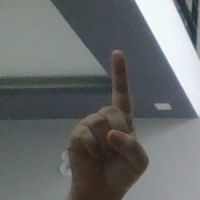

<IPython.core.display.Javascript object>

Saved to photo_1.jpg


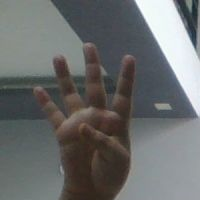

<IPython.core.display.Javascript object>

Saved to photo_2.jpg


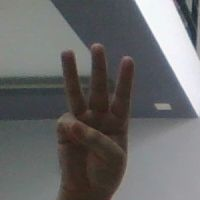

<IPython.core.display.Javascript object>

Saved to photo_3.jpg


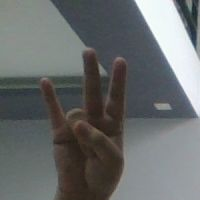

Success!, you are not a robot.


In [ ]:
from IPython.display import Image
from random import randint
i = 0
 
y=[]

# html code to display random captcha in a rectangular box  
display(HTML('''
<style>
#captcha{
  width:100px;
  height:50px;
  border: 2px solid #00f;
  background: #fff;
  padding-left:50px;
  
  }
 
</style>
<div> <p> Show hand gesture for this captcha:</p> </div>
<div id='captcha'> 
  <!-- <br> -->
<h2 id='num'></h2></div>
<script>
function random_num() {
 
  var val = Math.floor(Math.random()*9000) + 1000; // js functio to create a four digit random number 
  document.getElementById("num").innerHTML = val;
  return val;
}
</script>
 '''))
val = eval_js('random_num()') # store random number generated in val variable
for i in range(4):
  try:
    filename = take_photo(filename=f'photo_{i}.jpg')
    print('Saved to {}'.format(filename))
    # extract region of interest from image 
    imgX= cv2.imread(f'photo_{i}.jpg')
    imgX_crop= imgX[0:200,0:200]
    cv2_imshow(imgX_crop)
 
    imageYCrCb = cv2.cvtColor(imgX_crop, cv2.cv2.COLOR_BGR2YCR_CB)
    skinRegionYCrCb = cv2.inRange(imageYCrCb,min_YCrCb,max_YCrCb)
    skinYCrCb = cv2.bitwise_and(imgX_crop, imgX_crop, mask = skinRegionYCrCb) # mask to detect skin in the image
    imgX_crop = cv2.resize(skinYCrCb,(64,64))
    imgX_crop = cv2.GaussianBlur(imgX_crop,(3,3),0) # smoothening the masked image
    imgX_crop = cv2.morphologyEx(imgX_crop, cv2.MORPH_OPEN, kernel)  # morphological opening to remove noise in background without affecting the shape of foreground
    final_image = np.expand_dims(imgX_crop, axis=0)
    y_pred = model.predict(final_image)
    #print(y_pred)
    y.append(y_pred.argmax()) # append the predicted outcome to the list   
    
  except Exception as err:
    # Errors will be thrown if the user does not have a webcam or if they do not
    # grant the page permission to access it.
    print(str(err))
y_str = ''.join(map(str, y)) # concatenate all the predicted elements in the list to a string
if y_str == str(val): 
  print('Success!, you are not a robot.')
  display(HTML('''<div><button> Submit</button></div>'''))
else:
  print('Wrong Answer. try again.')
  display(HTML('''<div><button disabled> Submit</button></div>'''))


#References
---


*   HSV Skin color range https://stackoverflow.com/questions/8753833/exact-skin-color-hsv-range
*   YCrCb skin color range https://nalinc.github.io/blog/2018/skin-detection-python-opencv/
*   Gaussian Blurring https://docs.opencv.org/4.5.2/d4/d13/tutorial_py_filtering.html
*   Morphological Opening https://docs.opencv.org/4.5.2/d9/d61/tutorial_py_morphological_ops.html

*   Render HTML in colab https://stackoverflow.com/questions/51576756/display-render-an-html-file-inside-jupyter-notebook-on-google-colab-platform





